iter:5000 training loss: 0.004455320071429014, val loss: 0.004575524479150772
iter:10000 training loss: 0.0032422624062746763, val loss: 0.003359402297064662
iter:15000 training loss: 0.0026960463728755713, val loss: 0.002786818193271756
iter:20000 training loss: 0.0025304234586656094, val loss: 0.0025876115541905165
iter:25000 training loss: 0.0024673743173480034, val loss: 0.0025398824363946915
iter:30000 training loss: 0.002439501229673624, val loss: 0.002500463742762804
iter:35000 training loss: 0.0024278019554913044, val loss: 0.0024825118016451597
iter:40000 training loss: 0.002407402265816927, val loss: 0.002474111272022128
iter:45000 training loss: 0.00238559627905488, val loss: 0.002451756037771702
iter:50000 training loss: 0.002382751787081361, val loss: 0.0024442095309495926
iter:55000 training loss: 0.0023659784346818924, val loss: 0.002451443113386631
iter:60000 training loss: 0.0023932375479489565, val loss: 0.0024261390790343285
iter:65000 training loss: 0.00237727188505

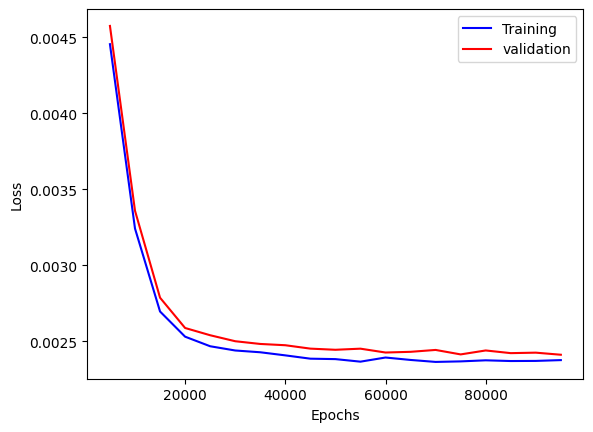

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px


def visualise_tensor(data):
    data = data.detach().numpy()

    ## Create colormap (red to blue)
    colormap = 'RdBu_r'
    # Plot the matrix
    fig = px.imshow(data, color_continuous_scale=colormap, zmin=-1, zmax=1, )
    fig.show()
    fig.data = ()

input_size = 20
hidden_layer_size= 5
output_size = input_size
learning_rate = 0.1
max_iters = 100000
dataset_size = 1024
sparsity = 0.99 # appears only one in 100 times
batch_size = 32

decay_factor = 0.95
iters = []
loss_value = []
val_loss_value = []

imp_vector =torch.tensor([0.7**i for i in range(input_size)])


def get_l1_penalty():
    l1_penalty = 0
    for param in model.parameters():
        if param.requires_grad:
            l1_penalty += torch.norm(param, p=1)
    return l1_penalty

def sample_data():
    # TODO Implement mini batch
    a,b = training_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = training_dataset*sparsity_mat
    return X, X

def sample_validation_data():
    a,b = validation_dataset.shape
    sparsity_mat = torch.bernoulli(torch.full((a,b), sparsity))
    X = validation_dataset*sparsity_mat
    return X, X


def get_loss(target, output):
    loss = (imp_vector*((target-output)**2)).mean()
    return loss


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_layer_size, bias= False)
        self.layer2 = nn.Linear(hidden_layer_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, input, targets = None):
         # Input is (B,I)
        logits = self.layer1(input) # (B, dim)
        
        #logits = self.layer2(logits)
        layer_1_weight = self.layer1.weight.data # (dim, I)
        logits = logits @ layer_1_weight # (B, dim) * (dim, I) -> (B,I)
        logits += self.layer2.bias

        #logits = self.relu(logits)
        if targets is None:
            return logits
        else:
            loss = get_loss(targets, logits)
            return logits, loss

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model()


optimizer = torch.optim.SGD(model.parameters() , learning_rate)
start_time = time.time()
step_value = max_iters/20
for i in range(1, max_iters):
    X, Y = sample_data()
    logits, loss = model(X, Y)
   
    if i%step_value ==0 :
        model.eval()
        with torch.no_grad():
            X_V,Y_V = sample_validation_data()
            _, val_loss = model(X_V, Y_V)
            iters.append(i)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss.item())
            print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    # loss+= get_l1_penalty()
    loss.backward()
    optimizer.step()


end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()




In [41]:
w1 = model.layer1.weight
w2 = model.layer2.weight
b1 = model.layer1.bias
b2 = model.layer2.bias
visualise_tensor(torch.transpose(w1,0,1)@w1)
visualise_tensor(b2.data.reshape(-1,1))

In [42]:
norm = [0 for i in range(input_size)]
for i in range(input_size):
    idx = torch.zeros(input_size)
    idx[i] = 1
    idx = w1@idx
    norm[i] = idx.norm()
norm = torch.tensor(norm)
visualise_tensor(norm.reshape(-1,1))

In [43]:
dot = [0 for i in range(input_size)]
for i in range(input_size):
    idx = torch.zeros(input_size)
    idx[i] = 1
    s = 0
    embed_a = w1@idx
    for j in range(input_size):
        if i==j:
            continue
        idx = torch.zeros(input_size)
        idx[j] = 1
        embed_b = w1@idx
        s+= (torch.dot(embed_a,embed_b))**2
    
    dot[i] = s

dot = torch.tensor(dot)
print(dot)
visualise_tensor(dot.reshape(-1,1))


tensor([4.1991e-07, 7.1072e-07, 2.0180e-06, 2.4364e-06, 9.2291e-04, 4.6189e-04,
        1.1442e-04, 4.0818e-05, 2.6532e-05, 3.7513e-05, 3.4221e-05, 2.6023e-05,
        1.9937e-05, 2.9131e-05, 2.0512e-05, 2.0986e-05, 2.1362e-05, 3.2506e-05,
        1.7695e-05, 1.9257e-05])
